## Generation of new RNAQuANet dataset

In [52]:
import pandas as pd
from Bio.PDB import PDBParser
import os
from pymol import cmd
from Bio.PDB import MMCIFParser
import Bio
from tqdm import tqdm
    


In [3]:
structure_list =  pd.read_csv('/home/adamczykb/rnaquanet/data/00_reference/BSGU__R__All__All__3_0__txt.txt')['structure'].unique().tolist()

In [121]:
structure_list_o = os.listdir(
    "/home/adamczykb/rnaquanet/data/00_reference/BGSU__R__All__All__4_0__cif_3_378"
)
structure_list = [x.split(".")[0] for x in structure_list_o]
structure_list = [x.replace("Chain_id", "") for x in structure_list]
structure_list = [stri.split("_") for stri in structure_list]
structure_list = pd.DataFrame(structure_list)[[0, 2]]
structure_list.rename(columns={0: "pdb_id", 2: "chain_id"}, inplace=True)
structure_list['path']= "/home/adamczykb/rnaquanet/data/00_reference/BGSU__R__All__All__4_0__cif_3_378/"+pd.Series(structure_list_o)

In [122]:
structure_list['res']=0.0
structure_list['res2']=0.0
structure_list['size']=0.0
structure_list['sequence']=''
structure_list['struct_keywords']=''
structure_list['type']=''


In [123]:
import json
from numpy import inf
import requests



r = requests.post(
    "https://data.rcsb.org/graphql",
    json={
        "query": """query Elements($pdb_ids:[String!]!) {
                        entries(entry_ids: $pdb_ids) {
                            refine{
                            ls_d_res_high
                            }
                            em_3d_reconstruction {
                            resolution
                            }
                            rcsb_entry_info {
                                polymer_entity_count_protein
                            }
                            entry {
                            id,
                            
                            },
                            struct_keywords {
                                pdbx_keywords
                                
                            },
                            struct_keywords {
                                pdbx_keywords
                                text
                            }
                            exptl {
                                method, 
                            }
                        }
                    }
                """,
        "variables": {"pdb_ids": list(structure_list['pdb_id'].unique().tolist())},
    },
)
for entry in json.loads(r.text)["data"]["entries"]:
    structure_list.loc[structure_list['pdb_id']==entry["entry"]["id"].upper(),'res'] = (entry["refine"][0]["ls_d_res_high"] if entry["refine"] else inf)
    structure_list.loc[structure_list['pdb_id']==entry["entry"]["id"].upper(),'res2'] = (entry["em_3d_reconstruction"][0]["resolution"] if entry["em_3d_reconstruction"] else inf)
    structure_list.loc[structure_list['pdb_id']==entry["entry"]["id"].upper(),'type'] = entry["struct_keywords"]['pdbx_keywords']
    if (
        "protein" in entry["struct_keywords"]["text"].lower()
        or "ribosom" in entry["struct_keywords"]["text"].lower()
        or "complex" in entry["struct_keywords"]["text"].lower()
        or entry["rcsb_entry_info"]["polymer_entity_count_protein"] > 0
    ):
        structure_list.loc[structure_list['pdb_id']==entry["entry"]["id"].upper(),'struct_keywords'] = 'complex'
        

    elif "dna" in entry["struct_keywords"]["text"].lower():
        structure_list.loc[structure_list['pdb_id']==entry["entry"]["id"].upper(),'struct_keywords'] = 'hybrid'


    elif "rna" in entry["struct_keywords"]["text"].lower():
        structure_list.loc[structure_list['pdb_id']==entry["entry"]["id"].upper(),'struct_keywords'] = 'solo'


    else:
        print(f"unknown: {entry}")


In [124]:
structure_list['resolution (A)'] = structure_list['res']
structure_list.loc[structure_list['resolution (A)']==inf,'resolution (A)'] = structure_list.loc[structure_list['resolution (A)']==inf,'res2']
structure_list=structure_list.drop(columns=['res','res2'])
structure_list=structure_list.drop(structure_list.loc[structure_list['resolution (A)']==inf].index)
structure_list = structure_list.drop_duplicates(subset=['pdb_id','chain_id'])

In [126]:
class RNA(Bio.PDB.Select):
    RNA_DICT_FULL = ['A', 'C', 'G', 'U','DU', 'A23', 'A2L', 'A2M', 'A39', 'A3P', 'A44', 'A5O', 'A6A', 'A7E', 'A9Z', 'ADI', 'ADP', 'AET', 'AMD', 'AMO', 'AP7', 'AVC', 'MA6', 'MAD', 'MGQ', 'MIA', 'MTU', 'M7A', '26A', '2MA', '6IA', '6MA', '6MC', '6MP', '6MT', '6MZ', '6NW', 'F3N', 'N79', 'RIA', 'V3L', 'ZAD', '31H', '31M', '7AT', 'O2Z', 'SRA', '00A', '45A', '8AN', 'LCA', 'P5P', 'PPU', 'PR5', 'PU', 'T6A', 'TBN', 'TXD', 'TXP', '12A', '1MA', '5FA', 'A6G', 'E6G', 'E7G', 'EQ4', 'IG', 'IMP', 'M2G', 'MGT', 'MGV', 'MHG', 'QUO', 'YG', 'YYG', '23G', '2EG', '2MG', '2SG', 'B8K', 'B8W', 'B9B', 'BGH', 'N6G', 'RFJ', 'ZGU', '7MG', 'CG1', 'G1G', 'G25', 'G2L', 'G46', 'G48', 'G7M', 'GAO', 'GDO', 'GDP', 'GH3', 'GNG', 'GOM', 'GRB', 'GTP', 'KAG', 'KAK', 'O2G', 'OMG', '8AA', '8OS', 'LG', 'PGP', 'P7G', 'TPG', 'TG', 'XTS', '102', '18M', '1MG', 'A5M', 'A6C', 'E3C', 'IC', 'M4C', 'M5M', '6OO', 'B8Q', 'B8T', 'B9H', 'JMH', 'N5M', 'RPC', 'RSP', 'RSQ', 'ZBC', 'ZCY', '73W', 'C25', 'C2L', 'C31', 'C43', 'C5L', 'CBV', 'CCC', 'CH', 'CSF', 'OMC', 'S4C', '4OC', 'LC', 'LHH', 'LV2', 'PMT', 'TC', '10C', '1SC', '5HM', '5IC', '5MC', 'A6U', 'IU', 'I4U', 'MEP', 'MNU', 'U25', 'U2L', 'U2P', 'U31', 'U34', 'U36', 'U37', 'U8U', 'UAR', 'UBB', 'UBD', 'UD5', 'UPV', 'UR3', 'URD', 'US5', 'UZR', 'UMO', 'U23', '2AU', '2MU', '2OM', 'B8H', 'FHU', 'FNU', 'F2T', 'RUS', 'ZBU', '3AU', '3ME', '3MU', '3TD', '70U', '75B', 'CNU', 'OMU', 'ONE', 'S4U', 'SSU', 'SUR', '4SU', '85Y', 'DHU', 'H2U', 'LHU', 'PSU', 'PYO', 'P4U', 'T31', '125', '126', '127', '1RN', '5BU', '5FU', '5MU', '9QV', '5GP']

    def __init__(self):
       pass

    def accept_residue(self, residue):
        return residue.get_resname() in self.RNA_DICT_FULL

In [127]:
from Bio.PDB.mmcifio import MMCIFIO

for structure in tqdm(structure_list['path'].tolist()):
    s=MMCIFParser().get_structure('str',structure)
    io = MMCIFIO()
    io.set_structure(s)
    io.save(
        structure,
        RNA(),
    )
    try:
        structure_list.loc[structure_list.path == structure,'size']=len(list(MMCIFParser().get_structure('str',structure).get_residues()))
    except:
        structure_list.loc[structure_list.path == structure,'size']=0

100%|██████████| 3310/3310 [07:34<00:00,  7.28it/s]


In [128]:
structure_list2 = structure_list[(structure_list['size']>=20)&(structure_list['size']<500)]

In [43]:
structure_list2

,pdb_id,chain_id,path,size,sequence,struct_keywords,type,resolution (A)
0,1QTQ,B,/home/adamczykb/rnaquanet/data/00_reference/BG...,74.0,GGGGUAUCGCCAAGCGGUAAGGCACCGGAUUCUGAUUCCGGCAUUC...,complex,LIGASE/RNA,2.25
1,8RD8,D8,/home/adamczykb/rnaquanet/data/00_reference/BG...,115.0,GCUGACGACCAUAGCACGAUGGCACCACCUGAUCCCUUCCCGAACU...,complex,RIBOSOME,2.62
2,7KRN,P-T,/home/adamczykb/rnaquanet/data/00_reference/BG...,80.0,CGUAGCAUGCUACGUCAUUCUCCUAAGAAGCUACCCC;CCCAUGUU...,complex,TRANSFERASE/HYDROLASE/RNA,3.40
3,5NWQ,A,/home/adamczykb/rnaquanet/data/00_reference/BG...,40.0,CCGGACGAGGUGCGCCGUACCCGGUCAGGACAAGACGGGC,solo,RNA,1.91
4,8G60,At,/home/adamczykb/rnaquanet/data/00_reference/BG...,69.0,GCCCGGAAGCUCAGCGGAGAGCAGGGGAUGAAACCCCGUUCCUUGG...,complex,RIBOSOME,2.54
...,...,...,...,...,...,...,...,...
1773,7F8Z,I-J,/home/adamczykb/rnaquanet/data/00_reference/BG...,36.0,GGCGAGAACCGGGGAGCC;GGCGAGAACCGGGGAGCC,solo,RNA,3.00
1774,6NU2,B,/home/adamczykb/rnaquanet/data/00_reference/BG...,56.0,AGAGUGUAGCUUAAAAGCACCCAACUUACACUUAGGAGAUUCAAUU...,complex,RIBOSOME,3.90
1775,6P5I,1,/home/adamczykb/rnaquanet/data/00_reference/BG...,205.0,CAUCAUUCUAUGGUUACCCAUCAUUAGAGGAAAUUUCCAAUAAACU...,complex,RIBOSOME,3.10
1776,2QWY,C,/home/adamczykb/rnaquanet/data/00_reference/BG...,52.0,GCGCGGCGAUUUAACCGUAUUGCAGUCGCGUGAUAAAUGUAGCUAA...,complex,RNA,2.80


In [20]:
structure_list2.to_csv('/home/adamczykb/rnaquanet/data/00_reference/selected_structures_for_dataset.csv',index=False)

In [56]:
structure_list2 = pd.read_csv('/home/adamczykb/rnaquanet/data/00_reference/selected_structures_for_dataset.csv')

In [58]:
for h, struct in structure_list2.iterrows():
    s = MMCIFParser().get_structure("str", struct["path"])[0]
    chains_ascending = sorted(struct["chain_id"].split("-"))
    sequences=[]
    for chain in chains_ascending:
        if chain in s:
            sequences.append(''.join([r.resname for r in s[chain].get_residues()]))
        else:
            chains_ascending.remove(chain)
    if len(chains_ascending)==0 or len(sequences)==0:
        structure_list2=structure_list2.drop(axis=1,index=h)
        print(f"{h} {struct}")
        continue
    structure_list2.loc[h,"chain_id"] = "-".join(chains_ascending)
    structure_list2.loc[h,"sequence"] = ";".join(sequences)

519 pdb_id                                                          8EA4
chain_id                                                         4-7
path               /home/adamczykb/rnaquanet/data/00_reference/BG...
size                                                           230.0
sequence                                                            
struct_keywords                                              complex
type                                     DNA BINDING PROTEIN/RNA/DNA
resolution (A)                                                   3.0
file                                        8EA4_1_7-1-4-3-2-5-6.cif
Name: 519, dtype: object


In [66]:
structure_list2

,pdb_id,chain_id,size,sequence,struct_keywords,type,resolution (A),file
0,1QTQ,B,74.0,GGGGUAUCGCCAAGCGGUAAGGCACCGGAUUCUGAUUCCGGCAUUC...,complex,LIGASE/RNA,2.25,1QTQ_1_B.cif
1,8RD8,D8,115.0,GCUGACGACCAUAGCACGAUGGCACCACCUGAUCCCUUCCCGAACU...,complex,RIBOSOME,2.62,8RD8_1_D8.cif
2,7KRN,P-T,80.0,CGUAGCAUGCUACGUCAUUCUCCUAAGAAGCUACCCC;CCCAUGUU...,complex,TRANSFERASE/HYDROLASE/RNA,3.40,7KRN_1_T-P.cif
3,5NWQ,A,40.0,CCGGACGAGGUGCGCCGUACCCGGUCAGGACAAGACGGGC,solo,RNA,1.91,5NWQ_1_A.cif
4,8G60,At,69.0,GCCCGGAAGCUCAGCGGAGAGCAGGGGAUGAAACCCCGUUCCUUGG...,complex,RIBOSOME,2.54,8G60_1_At.cif
...,...,...,...,...,...,...,...,...
1773,7F8Z,I-J,36.0,GGCGAGAACCGGGGAGCC;GGCGAGAACCGGGGAGCC,solo,RNA,3.00,7F8Z_1_I-J.cif
1774,6NU2,B,56.0,AGAGUGUAGCUUAAAAGCACCCAACUUACACUUAGGAGAUUCAAUU...,complex,RIBOSOME,3.90,6NU2_1_B.cif
1775,6P5I,1,205.0,CAUCAUUCUAUGGUUACCCAUCAUUAGAGGAAAUUUCCAAUAAACU...,complex,RIBOSOME,3.10,6P5I_1_1.cif
1776,2QWY,C,52.0,GCGCGGCGAUUUAACCGUAUUGCAGUCGCGUGAUAAAUGUAGCUAA...,complex,RNA,2.80,2QWY_1_C.cif


In [62]:
structure_list2.to_csv('/home/adamczykb/rnaquanet/data/00_reference/selected_structures_for_dataseto.csv',index=False)

In [63]:
import shutil
for h, struct in structure_list2.iterrows():
    shutil.copy(struct['path'], f'/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/{struct['path'].split('/')[-1]}')

In [64]:
for h, struct in structure_list2.iterrows():
    structure_list2.loc[h,'file']=struct['path'].split('/')[-1]

structure_list2=structure_list2.drop(columns='path',axis=0)



In [68]:
pd.set_option('display.max_rows', 2000)

In [70]:
structure_list2['sequence']

1777

In [71]:
structure_list2.to_csv('/home/adamczykb/rnaquanet/data/00_reference/selected_structures_for_dataset.csv',index=False)

In [7]:
structure_list2 = pd.read_csv('/home/adamczykb/rnaquanet/data/00_reference/selected_structures_for_dataset.csv')
structure_list2['boltz_prediciton_rmsd']=9999.0

In [29]:
structure_list2.shape[0] - structure_list2.loc[structure_list2['chain_id'].str.contains('-')].shape[0]

1300

In [27]:
import subprocess
for index, i in tqdm(structure_list2.iterrows()):
    cmd.reinitialize()
    cmd.load('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'+i['file'],object='reference')
    cmd.save('/home/adamczykb/rnaquanet/data/00_reference/fastas/'+i['file'].split('.')[0].replace('Chain_id','')+'.fasta')
    lines=[]
    with open('/home/adamczykb/rnaquanet/data/00_reference/fastas/'+i['file'].split('.')[0].replace('Chain_id','')+'.fasta','r') as f:
        lines=f.readlines()
    for l in range(len(lines)):
        if '>reference_' in lines[l]:
            lines[l]=lines[l].replace('>reference_','>').replace('\n','')+'|rna \n'
    with open('/home/adamczykb/rnaquanet/data/00_reference/fastas/'+i['file'].split('.')[0].replace('Chain_id','')+'.fasta','w') as f:
        f.seek(0)
        f.writelines(lines)

    # process = subprocess.Popen(
    #     ("docker run -it --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict "+'/data/fastas/'+i['file'].split('.')[0]+'.fasta'+ ' --accelerator gpu --output_format mmcif --out_dir '+ "/data/boltz_result/"+i['file'].split('.')[0]).split()
    # )
    # display(process.communicate())
    cmd.reinitialize()
    cmd.load('/home/adamczykb/rnaquanet/data/00_reference/boltz_result/'+i['file'].split('.')[0]+'_model_0.cif',object='boltz')
    cmd.load('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'+i['file'],object='reference')
    structure_list2.loc[i,'boltz_prediciton_rmsd']=cmd.align(f"boltz", "reference", cycles=0)[0]

1777it [00:08, 213.88it/s]


In [14]:

docker run -it --shm-size=2gb --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict /data/fastas/ --accelerator gpu --output_format mmcif --out_dir /data/boltz_result/         

In [25]:
' '.join(("docker run -it --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict "+'/data/fastas/'+i['file'].split('.')[0]+'.fasta'+ ' --accelerator gpu --output_format mmcif --out_dir '+ "/data/boltz_result/"+i['file'].split('.')[0]).split())


'docker run -it --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict /data/fastas/1QTQ_1_B.fasta --accelerator gpu --output_format mmcif --out_dir /data/boltz_result/1QTQ_1_B'

In [12]:
for index, i in tqdm(structure_list2.iterrows()):
    try:
        cmd.reinitialize()
        cmd.load('/home/adamczykb/rnaquanet/data/00_reference/boltz_result/boltz_results_fastas/predictions/'+i['file'].split('.')[0].replace('Chain_id','')+'/'+i['file'].replace('Chain_id','').split('.')[0]+'_model_0.cif',object='boltz')
        cmd.load('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'+i['file'],object='reference')
        structure_list2.loc[index,'boltz_prediciton_rmsd']=cmd.align(f"boltz", "reference", cycles=0)[0]
    except:
        display(f"{i} "+'/home/adamczykb/rnaquanet/data/00_reference/boltz_result/boltz_results_fastas/predictions/'+i['file'].split('.')[0].replace('Chain_id','')+'/'+i['file'].replace('Chain_id','').split('.')[0]+'_model_0.cif')

253it [00:02, 111.25it/s]

 Matrix: Warning: no convergence (0.00000010<225890.34375000 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<1265551.50000000 after 1000 iterations).


297it [00:02, 129.45it/s]

 Matrix: Warning: no convergence (0.00000010<1315587.00000000 after 1000 iterations).


432it [00:03, 98.04it/s] 

'pdb_id                                                          1E8S\nchain_id                                                           C\nsize                                                            43.0\nsequence                 CACAACCUUUCGGGGUGGGGCGAUCACAUGGGCGGUGAGUGUG\nstruct_keywords                                              complex\ntype                                  ALU RIBONUCLEOPROTEIN PARTICLE\nresolution (A)                                                   4.0\nfile                                                    1E8S_1_C.cif\nboltz_prediciton_rmsd                                         9999.0\nName: 437, dtype: object /home/adamczykb/rnaquanet/data/00_reference/boltz_result/boltz_results_fastas/predictions/1E8S_1_C/1E8S_1_C_model_0.cif'

471it [00:04, 102.28it/s]

 Matrix: Warning: no convergence (0.00000010<3510146.50000000 after 1000 iterations).


505it [00:04, 102.51it/s]

'pdb_id                                    4NIA\nchain_id                                   c-r\nsize                                      20.0\nsequence                 AAAAAAAAAA;UUUUUUUUUU\nstruct_keywords                        complex\ntype                                 VIRUS/RNA\nresolution (A)                            1.82\nfile                            4NIA_1_c-r.cif\nboltz_prediciton_rmsd                   9999.0\nName: 509, dtype: object /home/adamczykb/rnaquanet/data/00_reference/boltz_result/boltz_results_fastas/predictions/4NIA_1_c-r/4NIA_1_c-r_model_0.cif'

667it [00:06, 101.35it/s]

 Matrix: Warning: no convergence (0.00000010<2689487.25000000 after 1000 iterations).


743it [00:07, 92.15it/s] 

 Matrix: Warning: no convergence (0.00000010<2070653.62500000 after 1000 iterations).


954it [00:09, 86.04it/s] 

 Matrix: Warning: no convergence (0.00000010<1592722.50000000 after 1000 iterations).


995it [00:09, 86.85it/s]

 Matrix: Warning: no convergence (0.00000010<158599.42187500 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<1589700.62500000 after 1000 iterations).


1061it [00:10, 111.56it/s]

 Matrix: Warning: no convergence (0.00000010<1271243.87500000 after 1000 iterations).


1393it [00:13, 113.30it/s]

 Matrix: Warning: no convergence (0.00000010<1219290.12500000 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<2162063.75000000 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<671934.50000000 after 1000 iterations).


1686it [00:16, 114.10it/s]

 Matrix: Warning: no convergence (0.00000010<90545.94531250 after 1000 iterations).


1777it [00:17, 102.09it/s]


In [22]:
structure_list2 = structure_list2.drop(index=structure_list2.loc[structure_list2['boltz_prediciton_rmsd']==9999.0].index)

In [23]:
structure_list2.to_csv('/home/adamczykb/rnaquanet/data/00_reference/selected_structures_for_dataseto.csv',index=False)

Text(0, 0.5, 'RMSD boltz')

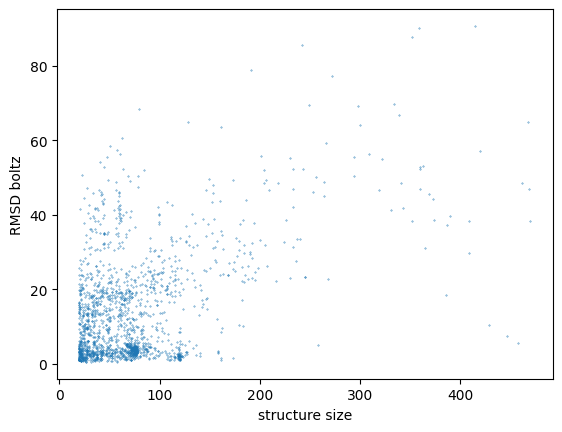

In [40]:
import matplotlib.pyplot as plt

plt.scatter(
    structure_list2[["size", "boltz_prediciton_rmsd"]].to_numpy()[:, 0],
    structure_list2[["size", "boltz_prediciton_rmsd"]].to_numpy()[:, 1],
    s=0.1,
)
plt.xlabel('structure size')
plt.ylabel('RMSD boltz')

Text(0, 0.5, 'RMSD boltz')

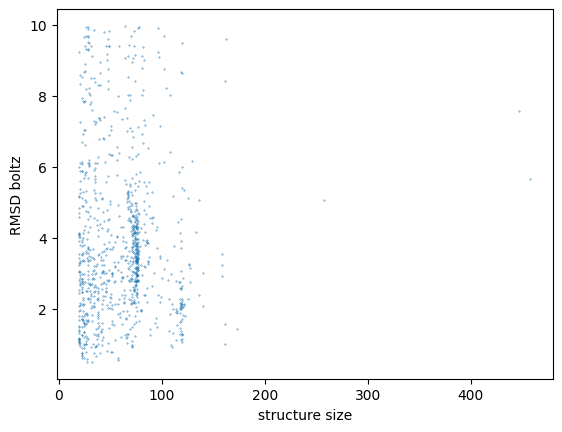

In [41]:
plt.scatter(
    structure_list2.loc[
        structure_list2["boltz_prediciton_rmsd"] < 10.0,
        ["size", "boltz_prediciton_rmsd"],
    ].to_numpy()[:, 0],
    structure_list2.loc[structure_list2['boltz_prediciton_rmsd']<10.0,['size','boltz_prediciton_rmsd']].to_numpy()[:,1],
    s=0.1,
)
plt.xlabel('structure size')
plt.ylabel('RMSD boltz')

Text(0.5, 0, 'RMSD boltz')

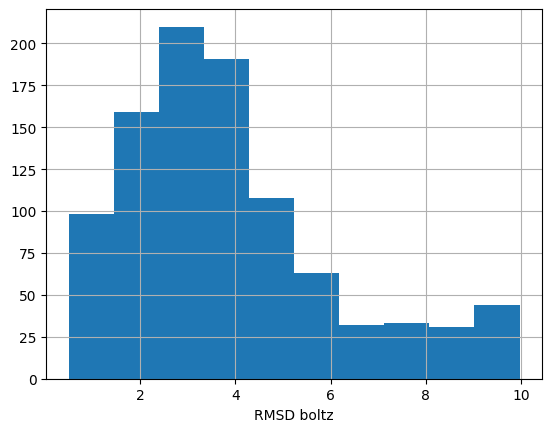

In [46]:
structure_list2.loc[
        structure_list2["boltz_prediciton_rmsd"] < 10.0,"boltz_prediciton_rmsd"
].hist()
plt.xlabel('RMSD boltz')

In [90]:
import random
import subprocess
import shutil
results=[]
for i in tqdm(range(100)):
    process = subprocess.Popen(f'docker run --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict /data/fastas/8G60_1_At.fasta --accelerator gpu --output_format mmcif --out_dir /data/boltz_resultt/ --seed {int(random.random()*10000000000)} --override'.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    while True:
        output = process.stdout.read()
        outputerr = process.stderr.read()
        if len(outputerr)>0:
            print(outputerr.decode())
        if process.poll() is not None:
            break
        if output:
            print(outputerr.decode().strip(),end='')
    
    cmd.reinitialize()
    cmd.load('/home/adamczykb/rnaquanet/data/00_reference/boltz_resultt/boltz_results_8G60_1_At/predictions/8G60_1_At/8G60_1_At_model_0.cif',object='boltz')
    cmd.load('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'+'8G60_1_At.cif',object='reference')
    results.append([i,cmd.align(f"boltz", "reference", cycles=0)[0]])
    print(f"RMSD: {results[-1]}")
    shutil.copy('/home/adamczykb/rnaquanet/data/00_reference/boltz_resultt/boltz_results_8G60_1_At/predictions/8G60_1_At/8G60_1_At_model_0.cif',f'/home/adamczykb/rnaquanet/data/00_reference/boltz_resultt/8G60_1_At/{i}.cif')
    # shutil.rmtree('/home/adamczykb/rnaquanet/data/00_reference/boltz_resultt/boltz_results_8G60_1_At')


  1%|          | 1/100 [00:23<39:08, 23.72s/it]

Seed set to 547277
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set

  2%|▏         | 2/100 [00:47<38:45, 23.73s/it]

Seed set to 485429
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set

  3%|▎         | 3/100 [01:11<38:21, 23.72s/it]

Seed set to 7083999
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

  4%|▍         | 4/100 [01:34<37:56, 23.71s/it]

Seed set to 1682265
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

  5%|▌         | 5/100 [01:58<37:36, 23.75s/it]

Seed set to 605453
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set

  6%|▌         | 6/100 [02:22<37:17, 23.80s/it]

Seed set to 3994669
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

  7%|▋         | 7/100 [02:46<36:46, 23.72s/it]

Seed set to 6032128
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

  8%|▊         | 8/100 [03:09<36:17, 23.67s/it]

Seed set to 7418484
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

  9%|▉         | 9/100 [03:33<35:54, 23.68s/it]

Seed set to 4270263
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 10%|█         | 10/100 [03:56<35:26, 23.63s/it]

Seed set to 1038771
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 11%|█         | 11/100 [04:20<35:08, 23.69s/it]

Seed set to 1789955
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 12%|█▏        | 12/100 [04:44<34:52, 23.78s/it]

Seed set to 769177
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set

 13%|█▎        | 13/100 [05:08<34:35, 23.86s/it]

Seed set to 6271095
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 14%|█▍        | 14/100 [05:32<34:09, 23.83s/it]

Seed set to 2008285
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 15%|█▌        | 15/100 [05:56<33:45, 23.83s/it]

Seed set to 2184412
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 16%|█▌        | 16/100 [06:20<33:23, 23.85s/it]

Seed set to 4921751
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 17%|█▋        | 17/100 [06:43<32:55, 23.81s/it]

Seed set to 4718128
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 18%|█▊        | 18/100 [07:07<32:31, 23.79s/it]

Seed set to 6579392
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se

 18%|█▊        | 18/100 [07:30<34:11, 25.02s/it]


KeyboardInterrupt: 

In [91]:
results

[[0, 4.307454586029053],
 [1, 4.252159595489502],
 [2, 3.916443109512329],
 [3, 4.332326889038086],
 [4, 4.287704944610596],
 [5, 4.20934534072876],
 [6, 4.933469295501709],
 [7, 4.506714344024658],
 [8, 4.300692558288574],
 [9, 4.488726615905762],
 [10, 4.385630130767822],
 [11, 4.562335968017578],
 [12, 4.437391757965088],
 [13, 4.599727153778076],
 [14, 4.150655746459961],
 [15, 4.440334320068359],
 [16, 4.0212178230285645],
 [17, 4.028461933135986]]

<Axes: >

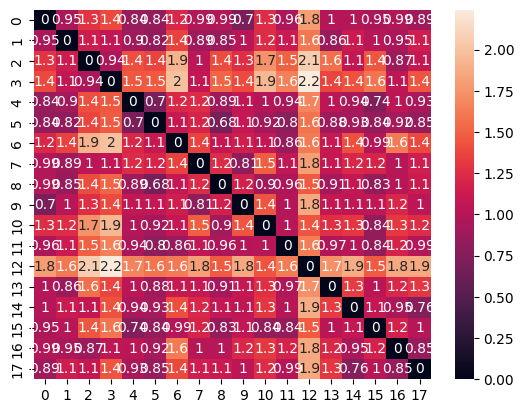

In [ ]:
import numpy as np
table = np.zeros((18,18))
for i in range(18):
    for j in range(i+1,18):
        cmd.reinitialize()
        cmd.load(f'/home/adamczykb/rnaquanet/data/00_reference/boltz_resultt/8G60_1_At/{i}.cif',object='boltz')
        cmd.load(f'/home/adamczykb/rnaquanet/data/00_reference/boltz_resultt/8G60_1_At/{j}.cif',object='reference')
        r=cmd.align(f"boltz", "reference", cycles=0)[0]
        table[i,j]=r
        table[j,i]=r
table



<Axes: >

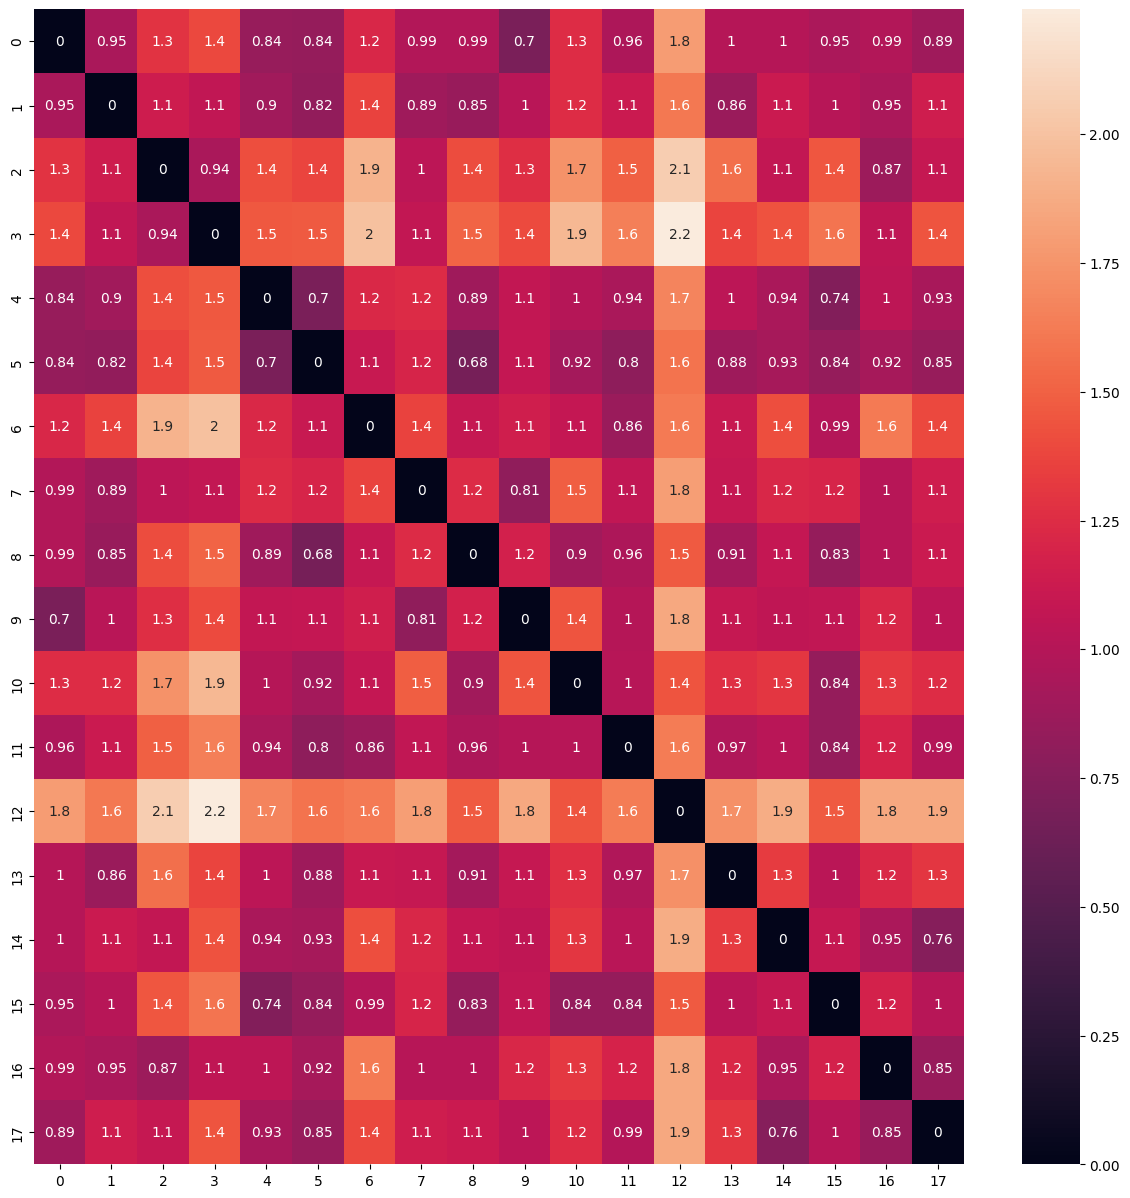

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(table,ax = ax, annot=True,)

In [63]:
f'docker run -it --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict /data/fastas/8G60_1_At.fasta --accelerator gpu --output_format mmcif --out_dir /data/boltz_resultt/ --seed {int(random.random())%5000} --override True'

'docker run -it --gpus all -v /home/adamczykb/rnaquanet/data/00_reference:/data boltz:latest boltz predict /data/fastas/8G60_1_At.fasta --accelerator gpu --output_format mmcif --out_dir /data/boltz_resultt/ --seed 0 --override True'

In [1]:
!pip3 install openmm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 3.1 MB/s eta 0:00:0000:0100:01


In [4]:
from openmm.app import *
from openmm import *
from openmm.unit import *
import mdtraj as md
import numpy as np
# Load a mmCIF file
pdb = PDBFile(
    "/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/1A9N_1_Q_fCIF.pdb"
)

# Create a force field
forcefield = ForceField('amber14/RNA.OL3.xml')

# System Configuration
system = forcefield.createSystem(pdb.topology,
    nonbondedMethod=NoCutoff,
    nonbondedCutoff=1.2*nanometers,
    constraints=HBonds,
    rigidWater=True
)

# Integrator Settings
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

# Simulation Platform
platform = Platform.getPlatformByName('CPU')  # Use OpenCL for AMD GPUs

# Create Simulation Object
simulation = Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

# --------------------------
# 4. System Solvation & Ionization
# --------------------------
# modeller = Modeller(pdb.topology, pdb.positions)
# modeller.addSolvent(forcefield, 
#     padding=1.0*nanometers,
#     ionicStrength=0.15*molar,
#     positiveIon='Na+',
#     negativeIon='Cl-'
# )

# # Update system with solvent
# system = forcefield.createSystem(modeller.topology,
#     nonbondedMethod=PME,
#     nonbondedCutoff=1.2*nanometers,
#     constraints=HBonds
# )

# --------------------------
# 5. Energy Minimization
# --------------------------
print("Minimizing energy...")
simulation.minimizeEnergy(maxIterations=1000)

# --------------------------
# 6. Equilibration Protocol
# --------------------------
# Positional restraints for RNA
# force = CustomExternalForce('k*((x-x0)^2+(y-y0)^2+(z-z0)^2)')
# force.addGlobalParameter('k', 100.0*kilojoule/mole/nanometer**2)
# force.addPerParticleParameter('x0')
# force.addPerParticleParameter('y0')
# force.addPerParticleParameter('z0')
# atoms=list(modeller.topology.atoms())
# for i in range(modeller.topology.getNumAtoms()):
#     if atoms[i].residue.name in ['A','U','G','C']:
#         force.addParticle(i, modeller.positions[i].value_in_unit(nanometers))
# system.addForce(force)

# 100 ps NVT equilibration
# simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
#     potentialEnergy=True, temperature=True))
simulation.step(50000)  # 0.002 ps/step

# --------------------------
# 7. Production MD Run
# --------------------------
# Remove positional restraints
# system.removeForce(len(system.getForces())-1)

# # Add barostat for NPT ensemble
# system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))

# # Configure output
# simulation.reporters.append(DCDReporter('trajectory.dcd', 1000))
# simulation.reporters.append(StateDataReporter('md_log.txt', 1000, 
#     step=True, time=True, potentialEnergy=True, temperature=True))

# # Run 100 ns production
# print("Running production MD...")
# simulation.step(50000)  # 100 ns simulation

# --------------------------
# 8. Trajectory Analysis
# --------------------------
# Load trajectory
traj = md.load('trajectory.dcd', top="/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/1A9N_1_Q_fCIF.pdb")

for i in range(50):
    traj[i].save_pdb('refined_structure.pdb')
    from pymol import cmd

    cmd.reinitialize()
    cmd.load('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/1A9N_1_Q_fCIF.pdb',object='reference')
    cmd.load('/home/adamczykb/rnaquanet/notebooks/'+'refined_structure.pdb',object='model2')
    print(cmd.align(f"model2", "reference", cycles=0)[0])


Minimizing energy...
45.0442008972168
45.420074462890625
45.1690673828125
44.98908233642578
45.02315139770508
45.40141296386719
45.57183074951172
45.74531173706055
45.79533386230469
45.351871490478516
45.665435791015625
45.789119720458984
45.92402267456055
46.2652473449707
45.894039154052734
46.01201248168945
45.80244445800781
46.41904067993164
45.8780517578125
45.984161376953125
45.809017181396484
45.9476203918457
45.58990478515625
45.482669830322266
45.919010162353516
45.7584228515625
45.60300064086914
45.84920883178711
46.354393005371094
46.41512680053711
46.760093688964844
46.373661041259766
46.424560546875
46.676185607910156
46.77662658691406
46.91847610473633
46.80586624145508
47.32893371582031
47.191646575927734
46.92900466918945
47.01331329345703
46.89687728881836
46.616703033447266
46.99886703491211
46.803531646728516
47.02527618408203
47.245689392089844
47.10748291015625
47.35215377807617
47.50548553466797


In [24]:
from Bio.PDB import MMCIFParser

for i in os.listdir('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'):
    if i.endswith('.cif'):
        try:
            MMCIFParser().get_structure('str', '/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'+i)
        except:
            print(i)
            os.remove('/home/adamczykb/rnaquanet/data/00_reference/newrnaquanet/'+i)

3K1V_1_A_new.cif
